## Categorical Perception: A Groundwork for Deep Learning
#### Laurent Bonnasse-Gahot & Jean-Pierre Nadal
Python notebook for reproducing Figure 7 (Categorical perception of a cat/dog circular continuum), presented in Section 3.3.1, and Figure C.1.

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rc={'font.size': 11, 'axes.labelsize': 14, 
    'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(rc=rc)
sns.set_style('ticks')

In [2]:
from matplotlib.offsetbox import OffsetImage,AnnotationBbox

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model

In [3]:
if not os.path.exists('fig'):
    os.makedirs('fig')

In [4]:
image_size = (180,180)

def open_continua(img_folder):
    morphed_imgs = []
    n_morphs = 8
    for i in range(4*(n_morphs-1)+1):
        img_path = os.path.join(img_folder, 'cat_dog_continua_{}.png'.format(i))        
        x = image.load_img(img_path, target_size=image_size)
        x = image.img_to_array(x)
        morphed_imgs.append(x)
    return np.array(morphed_imgs)

In [5]:
# distance between two activities
def cosine_distance(act1, act2):
    return (1 - np.dot(act1, act2)/(np.linalg.norm(act1)*np.linalg.norm(act2)))

In [6]:
# look at the last convolution layer of each block (layer #4, #8 and #12)
# and the global pooling layer, layer #14
# also include the last decisional layer, layer #16
def get_activation_model(model):
    layer_outputs = [layer.output for layer in np.array(model.layers)[[4,8,12,14,16]]]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    return activation_model

In [7]:
def compute_results(x_morph):
    df_pred = []
    df_neural_dist = []
    df_neural_dist_init = []
    df_input_dist = []
    alpha_range = np.arange(x_morph.shape[0])
    alpha_discrim_range = .5*(alpha_range[:-1]+alpha_range[1:])

    n_trials = 10
    for trial in range(n_trials):
        model_init = load_model('model/model_cat_dog_cnn_init_{}.h5'.format(trial))
        model = load_model('model/model_cat_dog_cnn_{}.h5'.format(trial))

        activation_model_init = get_activation_model(model_init)
        activation_model = get_activation_model(model)

        activation_layers_init = activation_model_init(x_morph, training=False)
        activation_layers = activation_model(x_morph, training=False)

        df_pred.append(pd.DataFrame(
                {'alpha':alpha_range,
                 'pred1':activation_layers[-1].numpy().squeeze(),
                 'pred2':1-activation_layers[-1].numpy().squeeze(),
                 'trial':trial}))

        for layer, activation_layer in enumerate(activation_layers_init[:-1]):
            df_neural_dist_init.append(pd.DataFrame(
                {'layer':layer+1,
                 'alpha_discrim':alpha_discrim_range,
                 'neural_dist':[cosine_distance(activation_layer[i].numpy().flatten(),
                                                activation_layer[i+1].numpy().flatten())
                                for i in range(x_morph.shape[0]-1)]}))
            
        for layer, activation_layer in enumerate(activation_layers[:-1]):
            df_neural_dist.append(pd.DataFrame(
                {'layer':layer+1,
                 'alpha_discrim':alpha_discrim_range,
                 'neural_dist':[cosine_distance(activation_layer[i].numpy().flatten(),
                                                activation_layer[i+1].numpy().flatten())
                                for i in range(x_morph.shape[0]-1)]}))

    df_input_dist.append(pd.DataFrame(
        {'alpha_discrim':alpha_discrim_range,
         'input_dist':[cosine_distance(x_morph[i].flatten(), 
                                       x_morph[i+1].flatten())
                       for i in range(x_morph.shape[0]-1)]}))

    df_pred = pd.concat(df_pred)
    df_input_dist = pd.concat(df_input_dist)
    df_neural_dist = pd.concat(df_neural_dist)
    df_neural_dist_init = pd.concat(df_neural_dist_init)

    return df_pred, df_input_dist, df_neural_dist, df_neural_dist_init

In [8]:
color_layer = sns.cubehelix_palette(n_colors=4, start=0.3, rot=0.3,
                                    light=0.75, dark=0.2, hue=0.8 , gamma=0.9)

In [9]:
def visualize_results_layers(x_morph, df_pred, df_neural_dist, df_neural_dist_init, ylim):
    fh = plt.figure(figsize=(15,3.5), dpi=300)
    ax1 = plt.subplot(111)
    sns.lineplot(x='alpha', y='pred1', data=df_pred, 
                 lw=2, ls='--', color='tab:blue', ax=ax1)
    sns.lineplot(x='alpha', y='pred2', data=df_pred,
                 lw=2, ls='--', color='tab:red', ax=ax1);
    ax2 = ax1.twinx() 

    sns.lineplot(x='alpha_discrim', y='neural_dist', hue='layer', data=df_neural_dist,
                 palette = color_layer,
                 lw=3, ax=ax2, legend=False)
    
    sns.lineplot(x='alpha_discrim', y='neural_dist', hue='layer', data=df_neural_dist_init,
                 palette = color_layer,
                 lw=3, ls='--', ax=ax2, legend=False, zorder=0)
    
    ax2.set_ylim(ylim)
        
    ax1.set_ylabel('categorical prediction')
    ax2.set_ylabel('neural distance')
    ax1.set_xlabel('\n\n\nimage continuum')
    
    ax1.set_xticks(np.arange(x_morph.shape[0]))
    ax1.set_xticklabels('')
    for i in range(0, x_morph.shape[0], 7):
        plt.axvline(i, ls=':', c='0.5', alpha=0.7, zorder=-1)

    for i, img in enumerate(x_morph):
        imgtmp = img.astype('uint8')
        ab = AnnotationBbox(OffsetImage(imgtmp, zoom=0.145),
                            (i, -0.2), 
                            frameon=False, annotation_clip=False)
        ax1.add_artist(ab)
    plt.show()

    return fh

In [10]:
def visualize_results_input(x_morph, df_pred, df_input_dist, ylim):
    fh = plt.figure(figsize=(15,3.5), dpi=300)
    ax1 = plt.subplot(111)
    sns.lineplot(x='alpha', y='pred1', data=df_pred, ci=None,
                 lw=2, ls='--', color='tab:blue', ax=ax1)
    sns.lineplot(x='alpha', y='pred2', data=df_pred, ci=None,
                 lw=2, ls='--', color='tab:red', ax=ax1)
    ax2 = ax1.twinx()
    ax2.plot(df_input_dist.alpha_discrim, df_input_dist.input_dist, color='tab:green', lw=3)

    ax2.set_ylim(ylim)
    
    ax1.set_ylabel('categorical prediction')
    ax2.set_ylabel('distance in pixel space')
    ax1.set_xlabel('\n\n\nimage continuum')

    ax1.set_xticks(np.arange(x_morph.shape[0]))
    ax1.set_xticklabels('')
    for i in range(0, x_morph.shape[0], 7):
        plt.axvline(i, ls=':', c='0.5', alpha=0.7, zorder=-1)

    for i, img in enumerate(x_morph):
        imgtmp = img.astype('uint8')
        ab = AnnotationBbox(OffsetImage(imgtmp, zoom=0.145),
                            (i, -0.2), 
                            frameon=False, annotation_clip=False)
        ax1.add_artist(ab)
    plt.show()
    
    return fh

In [11]:
x_morph_a = open_continua('./cat_dog_continua_a/')
x_morph_b = open_continua('./cat_dog_continua_b/')

In [12]:
df_pred_a, df_input_dist_a, df_neural_dist_a, df_neural_dist_init_a = compute_results(x_morph_a)
df_pred_b, df_input_dist_b, df_neural_dist_b, df_neural_dist_init_b = compute_results(x_morph_b)

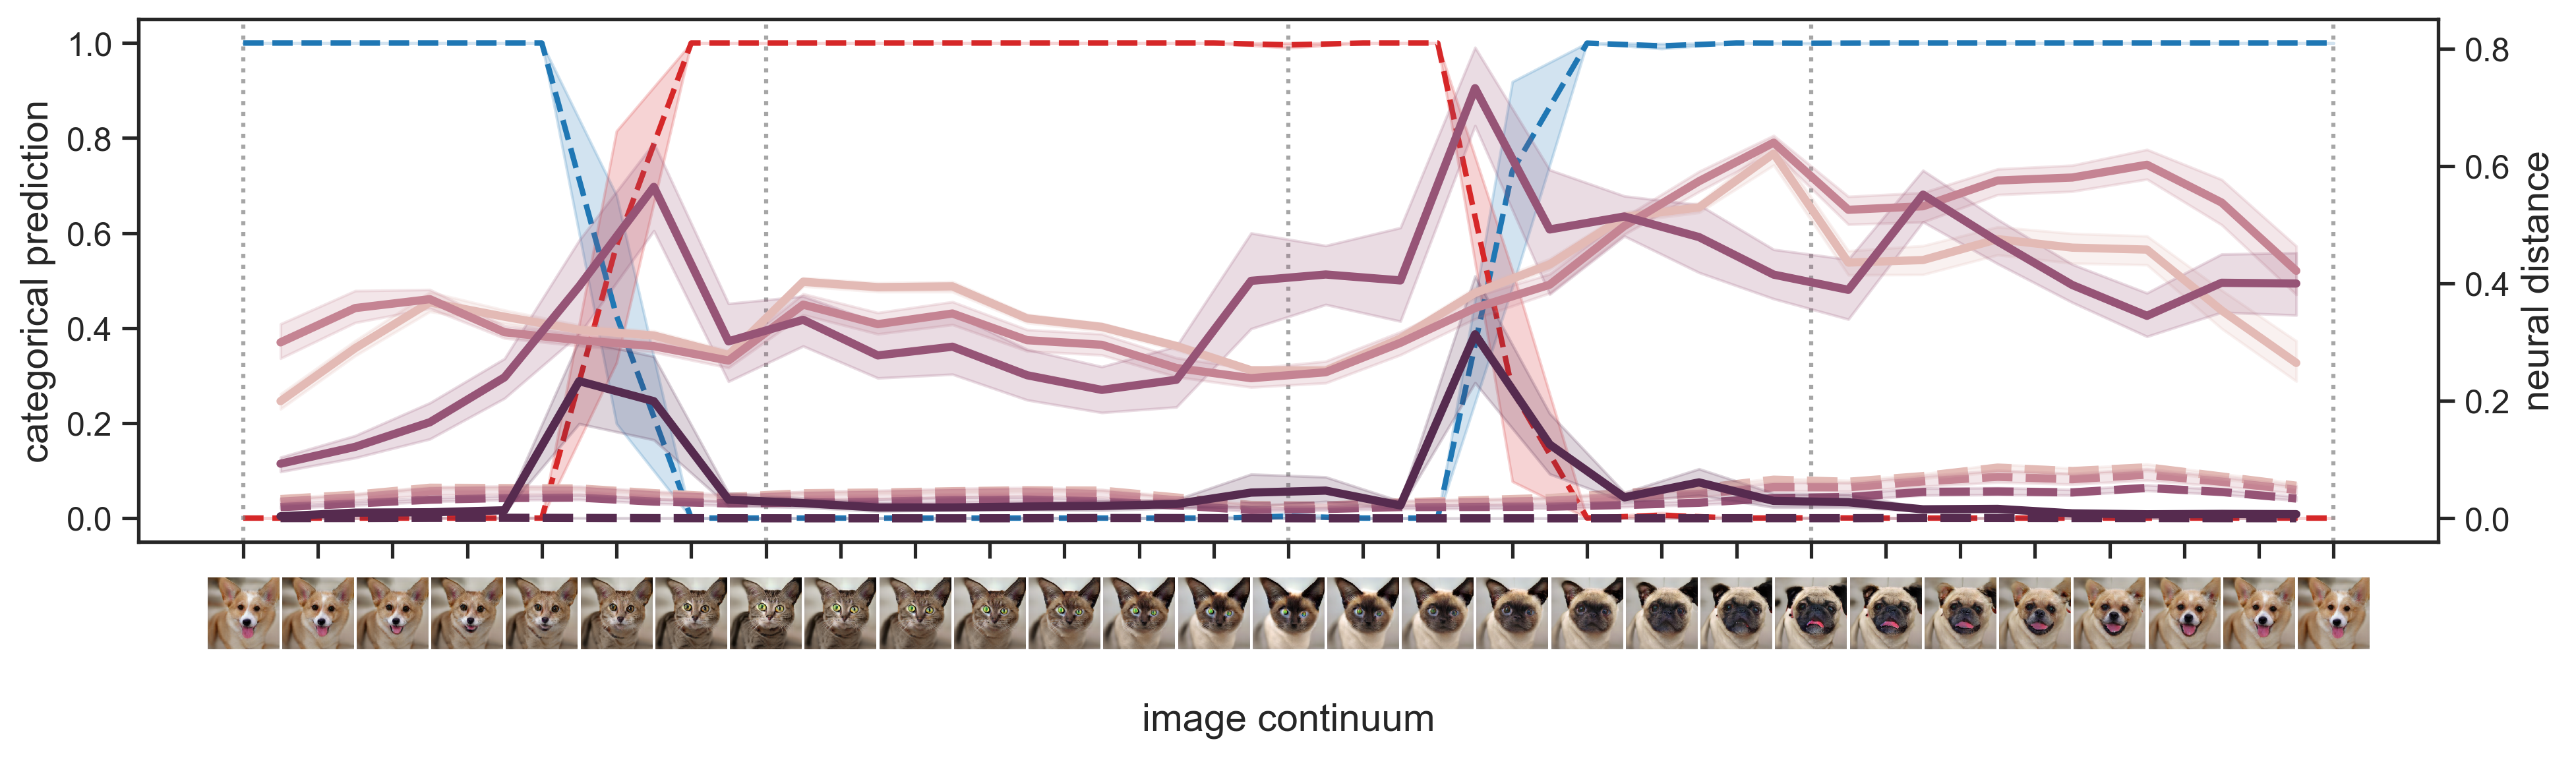

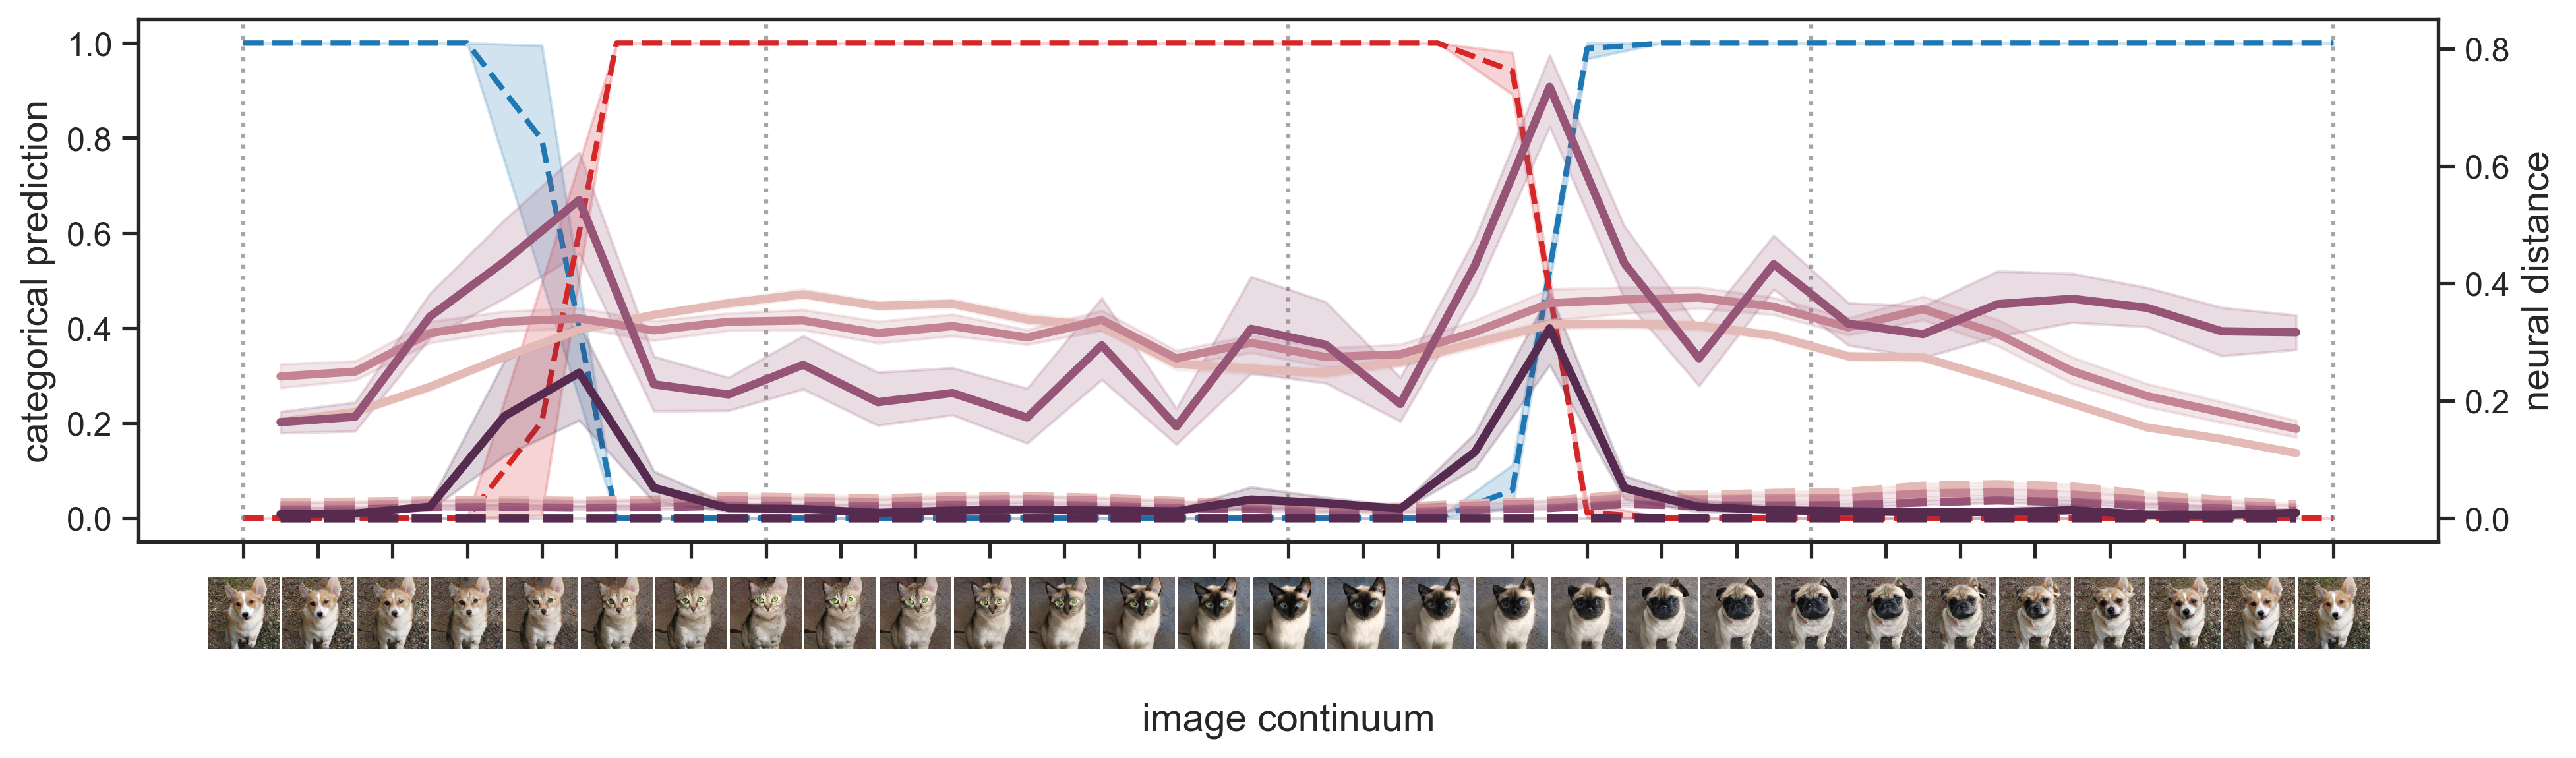

In [13]:
fh = visualize_results_layers(x_morph_a, df_pred_a, df_neural_dist_a, 
                              df_neural_dist_init_a, (-0.04, 0.85))
fh.savefig('fig/cat_dog_neuraldistance_a.pdf', bbox_inches='tight')

fh = visualize_results_layers(x_morph_b, df_pred_b, df_neural_dist_b, 
                              df_neural_dist_init_b, (-0.04, 0.85))
fh.savefig('fig/cat_dog_neuraldistance_b.pdf', bbox_inches='tight')

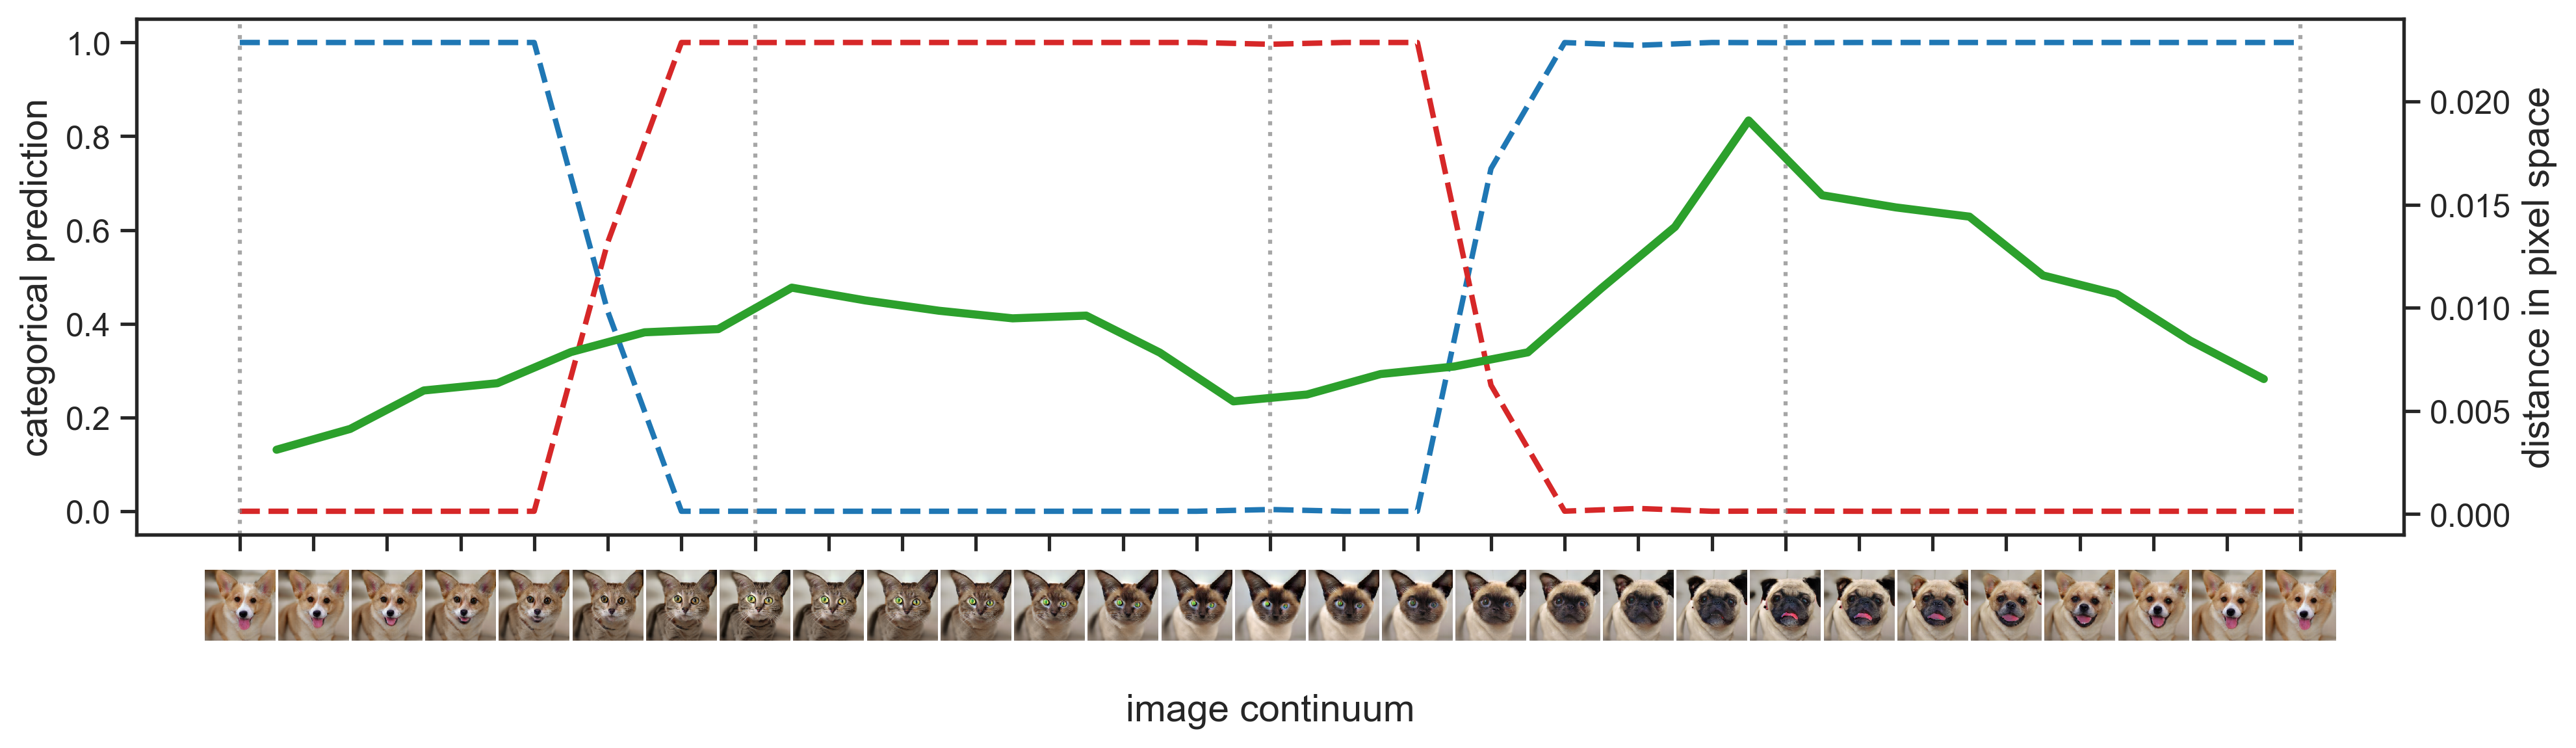

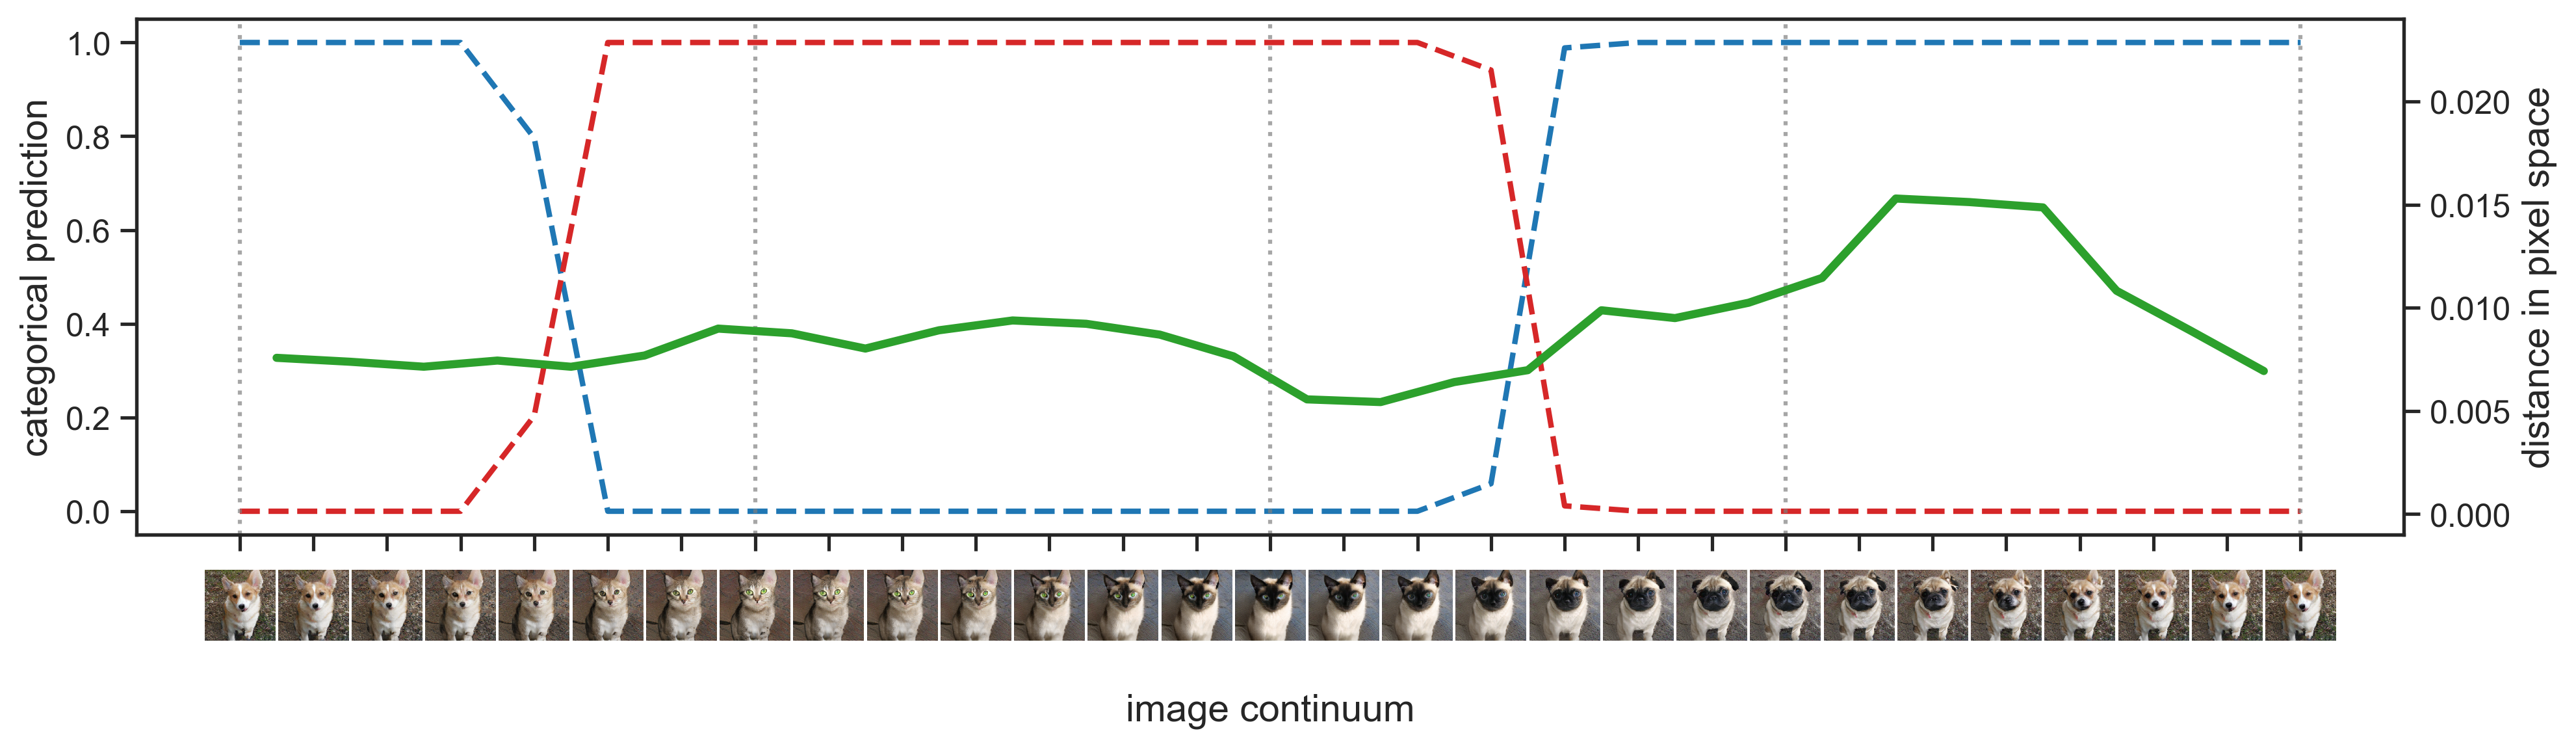

In [14]:
fh = visualize_results_input(x_morph_a, df_pred_a, df_input_dist_a, (-0.001, 0.024))
fh.savefig('fig/cat_dog_inputdistance_a.pdf', bbox_inches='tight')

fh = visualize_results_input(x_morph_b, df_pred_b, df_input_dist_b, (-0.001, 0.024))
fh.savefig('fig/cat_dog_inputdistance_b.pdf', bbox_inches='tight')